In [ ]:
# AW 7/17/2025
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as time

from collections import Counter,defaultdict
from warnings import simplefilter

# suppressing some warnings that, upon close inspection, are indeed useless
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

def read_in_data(file):
    df = pd.read_csv(".//ieee-fraud-detection//"+file+"_transaction.csv")
    # M4 column has weird values [M0,M1,M2],replacing with [0,1,2]
    # The remaining M1-M9 columns have T/F values replacing with 1/0
    # define a dictionary as a mapping function
    replace_mapping_Ms = {'F':0,'T':1,'M0':0,'M1':1,'M2':2}
    # replace each column with replaced values
    for i in range(9):
        df['M'+str(i+1)] = df['M'+str(i+1)].map(replace_mapping_Ms)
    print('Relabeling columns M1-M9')
    replace_mapping_ProdCD = {'W':1,'C':2,'R':3,'H':4,'S':5}
    df['ProductCD'] = df['ProductCD'].map(replace_mapping_ProdCD)
    replace_mapping_card4 = {'visa': 1, 'mastercard': 2, 'american express': 3, 'discover': 4}
    df['card4'] = df['card4'].map(replace_mapping_card4)
    replace_mapping_card6 = {'debit': 1, 'credit': 2, 'debit or credit': 3, 'charge card': 4}
    df['card6'] = df['card6'].map(replace_mapping_card6)
    print('Relabeling columns ProductCD,card4,card6')
    drop_list = []
    for i in range(15):
        df['D'+str(i+1)+'new'] = df['TransactionDT']//(60*60*24)-df['D'+str(i+1)]+2000
        drop_list.append('D'+str(i+1))
    print('Making new columns','new,'.join(drop_list)+'new')
    print('Dropping columns',','.join(drop_list))
    print()
    return df.drop(drop_list,axis=1)

def prep_data(df):
    print(f'Original memory footprint is {df.memory_usage(deep=True).sum()/2**20:.2f} MB')
    print('Typecasting to appropriate data types...')
    null_swap_value = -128 # arbitrary negnative number that is an int8
    for col in df:
        if df[col].dtype!=object and col!='TransactionAmt':
            df[col]=df[col].fillna(null_swap_value)
            if df[col].max()<128: df[col] = df[col].astype('int8')
            elif df[col].max()<32768: df[col] = df[col].astype('int16')
            else: df[col] = df[col].astype('int32')
        if col=='TransactionAmt':
            df[col] = df[col].astype('float32')
    print(f'Modified memory footprint is {df.memory_usage(deep=True).sum()/2**20:.2f} MB')
    print()
    print('Remaining non-int columns are the following:')
    for col in df.columns:
        if df[col].dtype!='int8' and df[col].dtype!='int16' and df[col].dtype!='int32':
            print('\t',col,df[col].dtype)
    print()
    return df

# for df only, not for use on df2 due to "isFraud" not being available
def count_ambiguous_UID(df):
    count_dict = defaultdict(list)
    c1 = Counter(df['UID'])
    c2 = Counter(df['UID'][df['isFraud']==1])
    for k,v in c2.items():
        count_dict[k].append(v)
    for k,v in c1.items():
        if k in count_dict:
            count_dict[k].append(v)
        else:
            count_dict[k]=[0,v]
    foo = pd.DataFrame(c1.most_common())
    foo = foo.rename(columns={0:'UID',1:'count'})
    foo['fraud_count'] = foo['UID'].map(c2)
    foo['fraud_frac'] = foo['fraud_count']/foo['count']
    # print('Total Groups:',len(foo['fraud_frac']))
    ambigious_count = ((foo['fraud_frac']>0)*(foo['fraud_frac']<1)).sum()
    print(f'Ambiguous Cases: {ambigious_count}')
    print(f'Ambiguous Fraction: {ambigious_count/len(df):1.3%}')
    return foo

def add_UID(df):
    df['UID'] =  df['card1'].astype(str)+'_'\
                +df['addr1'].astype(str)+'_'\
                +df['D1new'].astype(str)+'_'\
                +df['P_emaildomain'].astype(str)+'_'\
                +df['C1'].astype(str)+'_'\
                # +df['C5'].astype(str)+'_'\
                # +df['C13'].astype(str)+'_'\
                # +df['V303'].astype(str)+'_'\
                # +df['V125'].astype(str) 
    return df

In [722]:
print("Processing in train and test sets...")
df = read_in_data("train")
df = prep_data(df)
df2 = read_in_data("test")
df2 = prep_data(df2)

Processing in train and test sets...
Relabeling columns M1-M9
Relabeling columns ProductCD,card4,card6
Making new columns D1new,D2new,D3new,D4new,D5new,D6new,D7new,D8new,D9new,D10new,D11new,D12new,D13new,D14new,D15new
Dropping columns D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15

Original memory footprint is 1823.09 MB
Typecasting to appropriate data types...
Modified memory footprint is 439.91 MB

Remaining non-int columns are the following:
	 TransactionAmt float32
	 P_emaildomain object
	 R_emaildomain object

Relabeling columns M1-M9
Relabeling columns ProductCD,card4,card6
Making new columns D1new,D2new,D3new,D4new,D5new,D6new,D7new,D8new,D9new,D10new,D11new,D12new,D13new,D14new,D15new
Dropping columns D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15

Original memory footprint is 1561.36 MB
Typecasting to appropriate data types...
Modified memory footprint is 375.06 MB

Remaining non-int columns are the following:
	 TransactionAmt float32
	 P_emaildomain object
	 R_emaildo

In [ ]:
print('Adding UID to training set...')
df = add_UID(df)
c1 = Counter(df['UID'])
print(f'df UID count: {len(c1)}')
print(f'fraction of total transactions: {len(c1)/len(df):1.1%}')
bar = count_ambiguous_UID(df) #only valid for the training set, which is labeled
print('')

print('Adding UID to test set...')
df2 = add_UID(df2)
c2 = Counter(df2['UID'])
print(f'df2 UID count: {len(c2)}')
print(f'fraction of total transactions: {len(c2)/len(df2):1.1%}')
print('')

print(f'total UID count: {len(c1+c2)}')
print(f'overlapping UID count: {len(c1)+len(c2)-len(c1+c2)}')
print(f'overlapping UID fraction: {(len(c1)+len(c2))/len(c1+c2)-1:1.1%}')

Adding UID to training set...
df UID count: 325407
fraction of total transactions: 55.1%
Ambiguous Cases: 984
Ambiguous Fraction: 0.167%

Adding UID to test set...
df2 UID count: 275946
fraction of total transactions: 54.5%

total UID count: 583139
overlapping UID count: 18214
overlapping UID fraction: 3.1%


Text(0.5, 1.0, 'Ambigious Cases Not Separated by UID')

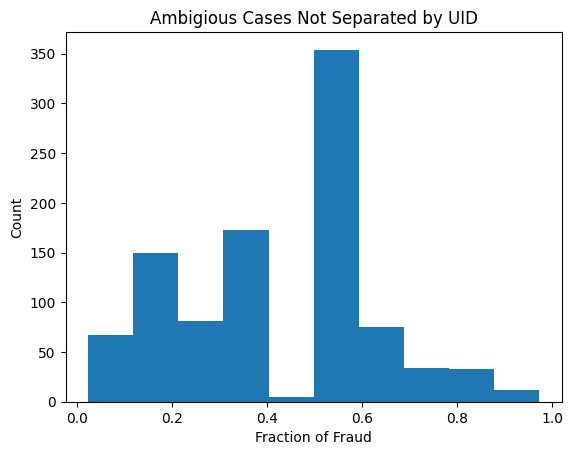

In [725]:
plt.hist(bar['fraud_frac'][(bar['fraud_frac']>0)*(bar['fraud_frac']<1)],bins=10)
plt.ylabel('Count')
plt.xlabel('Fraction of Fraud')
plt.title('Ambigious Cases Not Separated by UID')